# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
import joblib
import boto3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from implicit.als import AlternatingLeastSquares
from sklearn.preprocessing import LabelEncoder

/Users/andryousha/Projects/Python_projects/mle-project-sprint-4-v001/env_recsys_start/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [2]:
tracks = pd.read_parquet("tracks.parquet")
catalog_names = pd.read_parquet("catalog_names.parquet")
events = pd.read_parquet("interactions.parquet")

# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

##### Анализ tracks

In [3]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   albums    1000000 non-null  object
 2   artists   1000000 non-null  object
 3   genres    1000000 non-null  object
dtypes: int64(1), object(3)
memory usage: 30.5+ MB


In [4]:
# проверка на дубли
tracks.track_id.duplicated().sum() == 0

True

In [5]:
# дублей нет

In [6]:
tracks.head()

,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]
3,136,"[12, 214, 2490809]",[84],[11]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]


In [8]:
# надо преобразовать данные

In [9]:
tracks.isna().sum()

track_id    0
albums      0
artists     0
genres      0
dtype: int64

In [10]:
tracks = tracks \
    .explode(column=["albums"], ignore_index=True) \
    .explode(column=["artists"], ignore_index=True) \
    .explode(column=["genres"], ignore_index=True)

tracks.head()

,track_id,albums,artists,genres
0,26,3,16,11
1,26,3,16,21
2,26,2490753,16,11
3,26,2490753,16,21
4,38,3,16,11


In [11]:
tracks.isna().sum()

track_id        0
albums         18
artists     41789
genres      36675
dtype: int64

In [12]:
tracks.isna().sum() / tracks.shape[0]

track_id    0.000000
albums      0.000003
artists     0.006177
genres      0.005421
dtype: float64

In [13]:
# Доля наллов не особо критичная

In [20]:
# Поменяем все названия в id и будем придерживаться такого нейминга
tracks = tracks.rename(
    columns= {
        "albums": "album_id",
        "artists": "artist_id",
        "genres": "genre_id",
    }
)

tracks.head()

,track_id,album_id,artist_id,genre_id
0,26,3,16,11
1,26,3,16,21
2,26,2490753,16,11
3,26,2490753,16,21
4,38,3,16,11


##### Анализ catalog_names

In [22]:
catalog_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812471 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   type    object
 2   name    object
dtypes: int64(1), object(2)
memory usage: 41.5+ MB


In [23]:
catalog_names.head()

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack


In [24]:
catalog_names.isna().sum()

id      0
type    0
name    0
dtype: int64

In [25]:
# Нанов нет

In [26]:
catalog_names.type.value_counts()

type
track     1000000
album      658724
artist     153581
genre         166
Name: count, dtype: int64

In [30]:
genres = catalog_names.query("type == 'genre'").drop(columns="type")
genres.rename(columns={"id": "genre_id", "name": "genre"}, inplace=True)

genres.head(5)

,genre_id,genre
812305,0,all
812306,1,eastern
812307,2,rusrock
812308,3,rusrap
812309,4,postrock


In [31]:
track_names = catalog_names.query("type == 'track'").drop(columns="type")
track_names.rename(columns={"id": "track_id", "name": "track"}, inplace=True)

track_names.head(5)

,track_id,track
812471,26,Complimentary Me
812472,38,Momma's Boy
812473,135,Atticus
812474,136,24 Hours
812475,138,Don't Upset The Rhythm (Go Baby Go)


In [32]:
albums = catalog_names.query("type == 'album'").drop(columns="type")
albums.rename(columns={"id": "album_id", "name": "album"}, inplace=True)

albums.head(5)

,album_id,album
0,3,Taller Children
1,12,Wild Young Hearts
2,13,Lonesome Crow
3,17,Graffiti Soul
4,26,Blues Six Pack


In [33]:
artists = catalog_names.query("type == 'artist'").drop(columns="type")
artists.rename(columns={"id": "artist_id","name": "artist"}, inplace=True)

artists.head(5)

,artist_id,artist
658724,4,Kenny Dorham
658725,5,Max Roach
658726,7,Francis Rossi
658727,9,Status Quo
658728,12,Phil Everly


In [34]:
# Добавим к трекам различную информацию

In [35]:
items = tracks \
    .merge(track_names, on="track_id", how="left") \
    .merge(albums, on="album_id", how="left") \
    .merge(artists, on="artist_id", how="left") \
    .merge(genres, on="genre_id", how="left")

In [36]:
items = items[["track_id", "track", "artist", "album", "genre"]]
items.head(5)

,track_id,track,artist,album,genre
0,26,Complimentary Me,Elizabeth & the Catapult,Taller Children,pop
1,26,Complimentary Me,Elizabeth & the Catapult,Taller Children,folk
2,26,Complimentary Me,Elizabeth & the Catapult,Taller Children,pop
3,26,Complimentary Me,Elizabeth & the Catapult,Taller Children,folk
4,38,Momma's Boy,Elizabeth & the Catapult,Taller Children,pop


In [37]:
items.query("track_id == 26")

,track_id,track,artist,album,genre
0,26,Complimentary Me,Elizabeth & the Catapult,Taller Children,pop
1,26,Complimentary Me,Elizabeth & the Catapult,Taller Children,folk
2,26,Complimentary Me,Elizabeth & the Catapult,Taller Children,pop
3,26,Complimentary Me,Elizabeth & the Catapult,Taller Children,folk


In [38]:
# нужно зачистить дубликаты изза genre, оставим только первых

In [42]:
items = items.drop_duplicates('track_id', keep='first')
items.head(5)

,track_id,track,artist,album,genre
0,26,Complimentary Me,Elizabeth & the Catapult,Taller Children,pop
4,38,Momma's Boy,Elizabeth & the Catapult,Taller Children,pop
8,135,Atticus,Noisettes,Wild Young Hearts,pop
11,136,24 Hours,Noisettes,Wild Young Hearts,pop
14,138,Don't Upset The Rhythm (Go Baby Go),Noisettes,Wild Young Hearts,pop


In [43]:
assert items.track_id.duplicated().sum() == 0

In [45]:
items.isna().sum()

track_id        0
track           0
artist      15369
album          18
genre        3694
dtype: int64

In [46]:
items.isna().sum() / items.shape[0]

track_id    0.000000
track       0.000000
artist      0.015369
album       0.000018
genre       0.003694
dtype: float64

In [48]:
# также количество нуллов не существенно, но рассмотрим их более подробно

In [50]:
items[items.album.isna()]

,track_id,track,artist,album,genre
2730910,20200372,На скотч,NaN,NaN,NaN
2730923,20200380,Yo Te Quiero (Я тебя люблю),NaN,NaN,NaN
2739901,20305116,Мой путь,NaN,NaN,NaN
2739914,20305121,Вечность,NaN,NaN,NaN
2837815,20756854,Виновата,NaN,NaN,NaN
2879025,21196099,Are You with Me,NaN,NaN,NaN
2879037,21196103,Historia de Amor,NaN,NaN,NaN
2879042,21196105,Stronger Than Ever,NaN,NaN,NaN
2879051,21196107,Here We Go,NaN,NaN,NaN
2879058,21196109,Long Story Short,NaN,NaN,NaN


In [52]:
unknown_artists = items[items.artist.isna()]
unknown_artists.sample(10, random_state=42)

,track_id,track,artist,album,genre
6692475,91006543,"Женский тайм-менеджмент • Анна Всехсвятская, «...",NaN,Потом доделаю,podcasts
6251773,67572186,Комиксы для убогих // Отмена школьных экзамено...,NaN,Самые честные новости,podcasts
6562778,80807054,Образование будущего: каким оно будет,NaN,Smart Reading,podcasts
6043792,61064626,Владимир Седельников. Полярные летчики. Летать...,NaN,НЕБОНутые,podcasts
5685644,51684465,Что не так с сексом на постсоветском пространс...,NaN,Это разве секс? 18+,podcasts
5611891,50125505,"150: Все, что нужно знать о Falcon Heavy",NaN,The Big Beard Theory,podcasts
6525546,78880824,Рассказы для детей в исполнении автора. (читае...,NaN,Много букв,podcasts
6307438,69466617,Бритни Спирс в плену у собственного отца,NaN,Сплетни,podcasts
5785155,53689134,"«Хочу, но не могу»: как использовать психологи...",NaN,Игры разума,podcasts
6063192,61645665,0942 Daily Easy English Lesson PODCAST—to plug...,NaN,Daily Easy English Expression Podcast,podcasts


In [53]:
unknown_artists.genre.value_counts()

genre
podcasts            14954
fairytales            273
fiction                40
poemsforchildren       29
electronics            13
selfdevelopment        13
rock                    3
country                 2
community               2
pop                     1
forchildren             1
classical               1
local-indie             1
asmr                    1
work                    1
hls                     1
Name: count, dtype: int64

In [54]:
# В основном подкасты

In [55]:
items[items.genre.isna()].sample(10, random_state=42)

,track_id,track,artist,album,genre
1172203,1956422,All I Want for Christmas Is You,My Chemical Romance,Gift Wrapped: Regifted,NaN
6662702,88690682,Птеранодон,Pinkfong,Песни Про Динозавров,NaN
1409172,3861566,She's So Gone,Naomi Scott,Disney Singalong - Lemonade Mouth,NaN
2669653,19677621,Cannon in D,Classical Lullabies,Classical Lullabies,NaN
1884705,8656811,It's The Most Wonderful Time Of The Year,Rick Braun,Swingin' In The Snow,NaN
5462314,44904224,The Fall,My Little Pony,My Little Pony: The Movie,NaN
1430139,4079626,Bloody Mary,Twinkle Twinkle Little Rock Star,Lullaby Versions of Lady GaGa V.2,NaN
4256412,25164057,ACADECA,Twilight Sparkle,Friendship Games,NaN
3083083,21955336,Dance with the Devil,Twinkle Twinkle Little Rock Star,Lullaby Versions of Breaking Benjamin,NaN
4754746,33189013,That House,Dance With the Dead,B-Sides: Vol. 1,NaN


##### Анализ events

In [62]:
events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.4 GB


In [63]:
events.head(5)

,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21
3,0,590303,4,2022-07-22
4,0,590692,5,2022-07-22


In [68]:
print("ункальных юзеров в истории :", events.user_id.nunique())
print("ункальных треков в истории :", events.track_id.nunique())
print("минимальная дата :", events.started_at.min())
print("максимальная дата :", events.started_at.max())

ункальных юзеров в истории : 1373221
ункальных треков в истории : 1000000
минимальная дата : 2022-01-01 00:00:00
максимальная дата : 2022-12-31 00:00:00


In [69]:
# track_seq нам для простоты будет не нужен 
events.drop(columns='track_seq', inplace=True)

In [70]:
events.head(10)

,user_id,track_id,started_at
0,0,99262,2022-07-17
1,0,589498,2022-07-19
2,0,590262,2022-07-21
3,0,590303,2022-07-22
4,0,590692,2022-07-22
5,0,590803,2022-07-25
6,0,597196,2022-07-25
7,0,597199,2022-07-25
8,0,1750835,2022-07-30
9,0,1750843,2022-08-05


# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

- Есть неудобство таблицы catalog_names, которую разделил на 4 отдельные таблицы и добавил информацию в таблицу с треками
- В таблице с треками изначально были списки в качестве значений - пришлось раскрыть эти списки, но получились дубли по жанрам (взял из каджого слепка дублей только первое значение)

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

In [76]:
events["month"] = events["started_at"].dt.month
events.head(5)

,user_id,track_id,started_at,month
0,0,99262,2022-07-17,7
1,0,589498,2022-07-19,7
2,0,590262,2022-07-21,7
3,0,590303,2022-07-22,7
4,0,590692,2022-07-22,7


In [78]:
events = events.merge(
    items[["track_id", "track", "genre"]],
    on="track_id",
    how="left",
)
events.head(5)

,user_id,track_id,started_at,month,track,genre
0,0,99262,2022-07-17,7,Bad Bad Boys,pop
1,0,589498,2022-07-19,7,"Чао, бамбино",pop
2,0,590262,2022-07-21,7,Бомбей буги,pop
3,0,590303,2022-07-22,7,Bad Russians,pop
4,0,590692,2022-07-22,7,Великий инквизитор,pop


<Axes: >

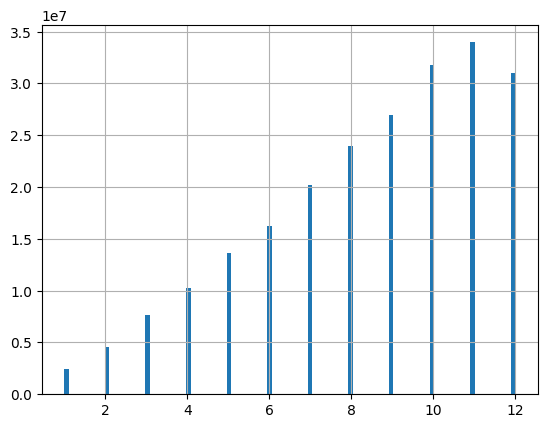

In [81]:
events['month'].hist(bins=100)

In [82]:
# Видим возрастающий тренд на кол-во прослушиваний в теч года

Наиболее популярные треки

In [86]:
top_20_songs = events.track_id \
                    .value_counts() \
                    .head(20) \
                    .reset_index() \
                    .merge(
                            items[["track_id", "track", "artist"]],
                            on="track_id",
                            how="left",
                        )[["track_id", "track", "artist", "count"]]
top_20_songs

,track_id,track,artist,count
0,53404,Smells Like Teen Spirit,Nirvana,111062
1,33311009,Believer,Imagine Dragons,106921
2,178529,Numb,Linkin Park,101924
3,35505245,I Got Love,Miyagi & Эндшпиль,99490
4,65851540,Юность,Dabro,86670
5,24692821,Way Down We Go,KALEO,86246
6,32947997,Shape of You,Ed Sheeran,85886
7,51241318,In The End,Tommee Profitt,85244
8,795836,Shape Of My Heart,Sting,85042
9,45499814,Life,Zivert,84748


Наиболее популярные жанры

In [88]:
events.genre.value_counts().head(20)

genre
pop            55505415
rusrap         25303695
electronics    18693208
dance          15409950
rusrock        13166147
foreignrap     11806841
rock           10358249
alternative     9935929
metal           6403355
indie           5451462
rusestrada      4885310
local-indie     4068187
punk            3543730
folk            3404546
numetal         2237558
shanson         2217170
soundtrack      2193647
films           2094014
hardrock        2054649
rnb             1922139
Name: count, dtype: int64

Треки, которые никто не прослушал

In [90]:
items_track_ids = set(items.track_id.values.tolist())
events_track_ids = set(events.track_id.values.tolist())

In [99]:
no_listens_track_ids = list(events_track_ids - events_track_ids)
print("Число треков, которые никто не слушал:", len(no_listens_track_ids))
print("Доля треков от всех треков, которые никто не слушал:", len(no_listens_track_ids) / items.shape[0])

Число треков, которые никто не слушал: 0
Доля треков от всех треков, которые никто не слушал: 0.0


In [101]:
# Все слушались хотя бы раз

# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

### Items

In [102]:
items.head(5)

,track_id,track,artist,album,genre
0,26,Complimentary Me,Elizabeth & the Catapult,Taller Children,pop
4,38,Momma's Boy,Elizabeth & the Catapult,Taller Children,pop
8,135,Atticus,Noisettes,Wild Young Hearts,pop
11,136,24 Hours,Noisettes,Wild Young Hearts,pop
14,138,Don't Upset The Rhythm (Go Baby Go),Noisettes,Wild Young Hearts,pop


In [103]:
items = items.reset_index(drop=True)
items.head(5)

,track_id,track,artist,album,genre
0,26,Complimentary Me,Elizabeth & the Catapult,Taller Children,pop
1,38,Momma's Boy,Elizabeth & the Catapult,Taller Children,pop
2,135,Atticus,Noisettes,Wild Young Hearts,pop
3,136,24 Hours,Noisettes,Wild Young Hearts,pop
4,138,Don't Upset The Rhythm (Go Baby Go),Noisettes,Wild Young Hearts,pop


In [104]:
# Закодируем track_id с 0
items_enc = LabelEncoder()
items_enc.fit(items["track_id"])
items["track_id_enc"] = items_enc.transform(items["track_id"])
items.head()

,track_id,track,artist,album,genre,track_id_enc
0,26,Complimentary Me,Elizabeth & the Catapult,Taller Children,pop,0
1,38,Momma's Boy,Elizabeth & the Catapult,Taller Children,pop,1
2,135,Atticus,Noisettes,Wild Young Hearts,pop,2
3,136,24 Hours,Noisettes,Wild Young Hearts,pop,3
4,138,Don't Upset The Rhythm (Go Baby Go),Noisettes,Wild Young Hearts,pop,4


In [105]:
items["track_id_enc"].min(), items["track_id_enc"].max()

(0, 999999)

In [106]:
# Сохраняем кодировщик

In [109]:
with open("item_enc.pkl", "wb") as fd:
        joblib.dump(items_enc, fd)

In [110]:
# посмотрим что по памяти
items.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   track_id      1000000 non-null  int32 
 1   track         1000000 non-null  object
 2   artist        984631 non-null   object
 3   album         999982 non-null   object
 4   genre         996306 non-null   object
 5   track_id_enc  1000000 non-null  int64 
dtypes: int32(1), int64(1), object(4)
memory usage: 320.4 MB


In [111]:
# int 64 -> int 32

In [112]:
items["track_id_enc"] = items["track_id_enc"].astype("int32")

In [113]:
items.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   track_id      1000000 non-null  int32 
 1   track         1000000 non-null  object
 2   artist        984631 non-null   object
 3   album         999982 non-null   object
 4   genre         996306 non-null   object
 5   track_id_enc  1000000 non-null  int32 
dtypes: int32(2), object(4)
memory usage: 316.6 MB


In [114]:
# немного, но все же

### Events

In [115]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222629898 entries, 0 to 222629897
Data columns (total 6 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   started_at  datetime64[ns]
 3   month       int32         
 4   track       object        
 5   genre       object        
dtypes: datetime64[ns](1), int32(3), object(2)
memory usage: 7.5+ GB


In [116]:
# многовато, можно срезать по пользователям, но попробую сделать на всех событиях

In [117]:
events.isna().sum()

user_id            0
track_id           0
started_at         0
month              0
track              0
genre         159631
dtype: int64

In [119]:
events.head(5)

,user_id,track_id,started_at,month,track,genre
0,0,99262,2022-07-17,7,Bad Bad Boys,pop
1,0,589498,2022-07-19,7,"Чао, бамбино",pop
2,0,590262,2022-07-21,7,Бомбей буги,pop
3,0,590303,2022-07-22,7,Bad Russians,pop
4,0,590692,2022-07-22,7,Великий инквизитор,pop


In [120]:
# удалим приджойнненые колонки, потом если что вернем по справочникам

In [121]:
events.drop(columns=['month','track','genre'], inplace=True)

In [123]:
events.head(5)

,user_id,track_id,started_at
0,0,99262,2022-07-17
1,0,589498,2022-07-19
2,0,590262,2022-07-21
3,0,590303,2022-07-22
4,0,590692,2022-07-22


In [125]:
# закодируем user_id и применим кодировщик для track_id (уже готовый кодировщик)

In [127]:
user_enc = LabelEncoder()
user_enc.fit(events["user_id"])
events["user_id_encoded"] = user_enc.transform(events["user_id"])
events["track_id_enc"] = items_enc.transform(events["track_id"])
events.head()

,user_id,track_id,started_at,user_id_encoded,track_id_enc
0,0,99262,2022-07-17,0,16078
1,0,589498,2022-07-19,0,60661
2,0,590262,2022-07-21,0,61135
3,0,590303,2022-07-22,0,61158
4,0,590692,2022-07-22,0,61386


In [129]:
with open("user_enc.pkl", "wb") as fd:
        joblib.dump(user_enc, fd)

# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [180]:
import boto3
import os
from dotenv import load_dotenv

load_dotenv(override=True)

def check_creds():
    print(os.getenv('S3_URL'))

In [181]:
check_creds()

https://storage.yandexcloud.net


In [182]:
session = boto3.session.Session()

s3_client = session.client(
    service_name='s3',
    aws_access_key_id=os.getenv('AWS_ACCESS_KEY_ID'),
    aws_secret_access_key=os.getenv('AWS_SECRET_ACCESS_KEY'),
    endpoint_url=os.getenv('S3_URL')
)

In [188]:
s3_client.list_objects(Bucket=os.getenv('S3_BUCKET_NAME'), Prefix='')

{'ResponseMetadata': {'RequestId': '0b69901ae10a3050',
  'HostId': '',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'server': 'nginx',
   'date': 'Sun, 06 Jul 2025 05:33:39 GMT',
   'content-type': 'application/xml; charset=UTF-8',
   'content-length': '621',
   'connection': 'keep-alive',
   'keep-alive': 'timeout=60',
   'x-amz-request-id': '0b69901ae10a3050'},
  'RetryAttempts': 0},
 'IsTruncated': False,
 'Marker': '',
 'Contents': [{'Key': 'test/tracks.parquet',
   'LastModified': datetime.datetime(2025, 7, 6, 5, 32, 28, 839000, tzinfo=tzutc()),
   'ETag': '"6b7032500954d5ba6e545bb7463d60f2-3"',
   'Size': 18938128,
   'StorageClass': 'STANDARD',
   'Owner': {'DisplayName': 'ajeq26s98m0ssapaa27m',
    'ID': 'ajeq26s98m0ssapaa27m'}}],
 'Name': 's3-student-mle-20240822-bf0f64ea21',
 'Prefix': '',
 'MaxKeys': 1000,
 'EncodingType': 'url'}

In [190]:
os.mkdir('data')

In [191]:
items.to_parquet("data/items.parquet")
events.to_parquet("data/events.parquet")

In [192]:
path = 'recsys/data/'

In [195]:
s3_client.upload_file(Bucket=os.getenv('S3_BUCKET_NAME'), Filename='data/items.parquet', Key=path + 'items.parquet')

In [196]:
s3_client.upload_file(Bucket=os.getenv('S3_BUCKET_NAME'), Filename='data/events.parquet', Key=path + 'events.parquet')

In [197]:
s3_client.list_objects(Bucket=os.getenv('S3_BUCKET_NAME'), Prefix=path)

{'ResponseMetadata': {'RequestId': 'c44d19288c724bf3',
  'HostId': '',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'server': 'nginx',
   'date': 'Sun, 06 Jul 2025 05:48:02 GMT',
   'content-type': 'application/xml; charset=UTF-8',
   'content-length': '987',
   'connection': 'keep-alive',
   'keep-alive': 'timeout=60',
   'x-amz-request-id': 'c44d19288c724bf3'},
  'RetryAttempts': 0},
 'IsTruncated': False,
 'Marker': '',
 'Contents': [{'Key': 'recsys/data/events.parquet',
   'LastModified': datetime.datetime(2025, 7, 6, 5, 48, 2, 314000, tzinfo=tzutc()),
   'ETag': '"6fdb038c0823d5497c27bef71723d4ba-221"',
   'Size': 1853410180,
   'StorageClass': 'STANDARD',
   'Owner': {'DisplayName': 'ajeq26s98m0ssapaa27m',
    'ID': 'ajeq26s98m0ssapaa27m'}},
  {'Key': 'recsys/data/items.parquet',
   'LastModified': datetime.datetime(2025, 7, 6, 5, 43, 26, 74000, tzinfo=tzutc()),
   'ETag': '"27788f900b38614b7e1214bc251c1b68-5"',
   'Size': 37600409,
   'StorageClass': 'STANDARD',
   'Owner': {'Disp

# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

Просто перезапустим кернел и выполним самую первую ячейку с импортами

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [2]:
items = pd.read_parquet("data/items.parquet")
events = pd.read_parquet("data/events.parquet")

In [3]:
items.head(5)

,track_id,track,artist,album,genre,track_id_enc
0,26,Complimentary Me,Elizabeth & the Catapult,Taller Children,pop,0
1,38,Momma's Boy,Elizabeth & the Catapult,Taller Children,pop,1
2,135,Atticus,Noisettes,Wild Young Hearts,pop,2
3,136,24 Hours,Noisettes,Wild Young Hearts,pop,3
4,138,Don't Upset The Rhythm (Go Baby Go),Noisettes,Wild Young Hearts,pop,4


In [4]:
events.head(5)

,user_id,track_id,started_at,user_id_encoded,track_id_enc
0,0,99262,2022-07-17,0,16078
1,0,589498,2022-07-19,0,60661
2,0,590262,2022-07-21,0,61135
3,0,590303,2022-07-22,0,61158
4,0,590692,2022-07-22,0,61386


In [5]:
with open("user_enc.pkl", "rb") as fd:
        user_encoder = joblib.load(fd)

In [6]:
with open("item_enc.pkl", "rb") as fd:
    item_encoder = joblib.load(fd)

# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [7]:
# сначала нужно ввести целевую переменную ~ рейтинг, сделаем нормальзованное количество прослушеваний от максимального в границах [0:1]

In [8]:
events.head(5)

,user_id,track_id,started_at,user_id_encoded,track_id_enc
0,0,99262,2022-07-17,0,16078
1,0,589498,2022-07-19,0,60661
2,0,590262,2022-07-21,0,61135
3,0,590303,2022-07-22,0,61158
4,0,590692,2022-07-22,0,61386


In [9]:
track_pop = events.groupby("track_id_enc")["user_id_encoded"].count()
track_pop /= track_pop.max()
track_pop = track_pop.reset_index()
track_pop = track_pop.rename(
    columns={
        "user_id_encoded": "tracks_played"
    }
)
track_pop

,track_id_enc,tracks_played
0,0,0.000045
1,1,0.000072
2,2,0.000144
3,3,0.000063
4,4,0.000153
...,...,...
999995,999995,0.000054
999996,999996,0.000648
999997,999997,0.000081
999998,999998,0.000180


In [10]:
events = events.merge(
    track_pop,
    on="track_id_enc",
    how="left"
)
events.head()

,user_id,track_id,started_at,user_id_encoded,track_id_enc,tracks_played
0,0,99262,2022-07-17,0,16078,0.022726
1,0,589498,2022-07-19,0,60661,0.021538
2,0,590262,2022-07-21,0,61135,0.005132
3,0,590303,2022-07-22,0,61158,0.003854
4,0,590692,2022-07-22,0,61386,0.002215


<Axes: >

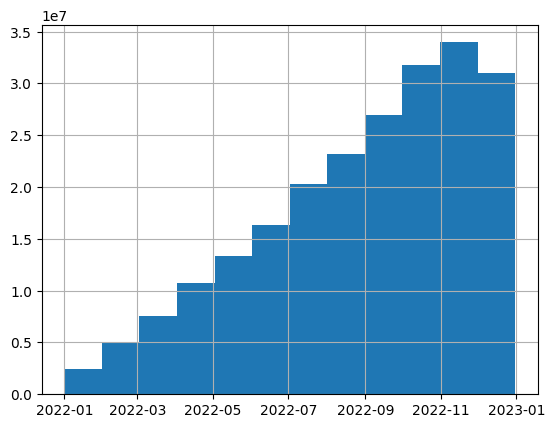

In [11]:
events['started_at'].hist(bins=12)

In [12]:
# оставим последний месяц на тест (глобальный трешхолд)

In [13]:
train_test_global_time_split_date = pd.to_datetime("2022-12-01")

train_test_global_time_split_idx = events["started_at"] < train_test_global_time_split_date
events_train = events[train_test_global_time_split_idx].copy()
events_test = events[~train_test_global_time_split_idx].copy()

print("Train: {:,}".format(events_train.shape[0]))
print("Test: {:,}".format(events_test.shape[0]))

Train: 191,586,163
Test: 31,043,735


In [14]:
# Посмотрим еще на юзеров, которые попали в выборки

In [15]:
events_train

,user_id,track_id,started_at,user_id_encoded,track_id_enc,tracks_played
0,0,99262,2022-07-17,0,16078,0.022726
1,0,589498,2022-07-19,0,60661,0.021538
2,0,590262,2022-07-21,0,61135,0.005132
3,0,590303,2022-07-22,0,61158,0.003854
4,0,590692,2022-07-22,0,61386,0.002215
...,...,...,...,...,...,...
222629733,1374582,58847203,2022-11-29,1373220,765960,0.004403
222629734,1374582,59140485,2022-11-30,1373220,768742,0.024905
222629735,1374582,59572098,2022-11-30,1373220,772963,0.016936
222629736,1374582,60450775,2022-11-30,1373220,780944,0.094578


In [16]:
users_train = events_train["user_id_encoded"].drop_duplicates().tolist()
users_test = events_test["user_id_encoded"].drop_duplicates().tolist()

common_users = set(users_train) & set(users_test)
cold_users = (set(users_train) | set(users_test)) - set(users_train)

print("Число уникальных юзеров в трейне : {:,}".format(len(users_train)))
print("Число уникальных юзеров в тесте: {:,}".format(len(users_test)))
print("Число общих юзеров: {:,}".format(len(common_users)))
print("Число холодных юзеров: {:,}".format(len(cold_users)))

Число уникальных юзеров в трейне : 1,294,970
Число уникальных юзеров в тесте: 995,485
Число общих юзеров: 917,234
Число холодных юзеров: 78,251


# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [17]:
# Возьмем топ 100 треков

In [18]:
top_100_popular = events_train.track_id \
                        .value_counts() \
                        .head(100) \
                        .reset_index() \
                        .rename(
                            columns={
                                "count": "tracks_played",
                            }
                        ).merge(
                            items[["track_id", "track", "artist"]],
                            on="track_id",
                            how="left",
                        )[["track_id", "track", "artist", "tracks_played"]]
top_100_popular["track_id_encoded"] = item_encoder.transform(top_100_popular["track_id"])
top_100_popular

,track_id,track,artist,tracks_played,track_id_encoded
0,53404,Smells Like Teen Spirit,Nirvana,107608,9098
1,178529,Numb,Linkin Park,98444,26665
2,33311009,Believer,Imagine Dragons,93384,483876
3,35505245,I Got Love,Miyagi & Эндшпиль,89879,512157
4,795836,Shape Of My Heart,Sting,81219,90461
...,...,...,...,...,...
95,56920237,Beverly Hills,Zivert,42856,749870
96,69542,Big City Life,Mattafix,42760,11289
97,14701552,How You Remind Me,Nickelback,42633,244930
98,32182642,Лирика,Filatov & Karas,42481,461481


In [19]:
top_100_popular.to_parquet("data/top_100_popular.parquet")

# Персональные

Рассчитаем персональные рекомендации.

In [20]:
# сначала создадим разреженную матрицу

In [21]:
events_train

,user_id,track_id,started_at,user_id_encoded,track_id_enc,tracks_played
0,0,99262,2022-07-17,0,16078,0.022726
1,0,589498,2022-07-19,0,60661,0.021538
2,0,590262,2022-07-21,0,61135,0.005132
3,0,590303,2022-07-22,0,61158,0.003854
4,0,590692,2022-07-22,0,61386,0.002215
...,...,...,...,...,...,...
222629733,1374582,58847203,2022-11-29,1373220,765960,0.004403
222629734,1374582,59140485,2022-11-30,1373220,768742,0.024905
222629735,1374582,59572098,2022-11-30,1373220,772963,0.016936
222629736,1374582,60450775,2022-11-30,1373220,780944,0.094578


In [22]:
user_item_matrix_train = scipy.sparse.csr_matrix(
    (
    events_train["tracks_played"],
    (events_train["user_id_encoded"], events_train["track_id_enc"])
    ),
    dtype=np.int8
)
user_item_matrix_train

<1373221x1000000 sparse matrix of type '<class 'numpy.int8'>'
	with 191586163 stored elements in Compressed Sparse Row format>

In [23]:
# Теперь применим ALS

In [24]:
als_params = {
    "factors": 40,
    "iterations": 40,
    "regularization": 0.05,
    "random_state": 42,
}

als_model = AlternatingLeastSquares(**als_params)
als_model.fit(user_item_matrix_train)

/Users/andryousha/Projects/Python_projects/mle-project-sprint-4-v001/env_recsys_start/lib/python3.9/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 10 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [46:22<00:00, 69.57s/it]


In [26]:
# Все закодированные идентификаторы пользователей
user_ids_encoded = range(len(user_encoder.classes_))

# Делаем рекомендации на всех юзеров
als_recommendations = als_model.recommend(
    user_ids_encoded, 
    user_item_matrix_train[user_ids_encoded], 
    filter_already_liked_items=False, 
    N=10,
)

In [27]:
# Приведем рекомендации к более читаемому виду

In [28]:
# Separating identifiers and ALS-scores
track_ids_encoded = als_recommendations[0]
als_scores = als_recommendations[1]

als_recommendations = pd.DataFrame({
    "user_id_encoded": user_ids_encoded,
    "track_id_encoded": track_ids_encoded.tolist(), 
    "score": als_scores.tolist(),
})
als_recommendations = als_recommendations.explode(["track_id_encoded", "score"], ignore_index=True)

# Сменим типы
als_recommendations["track_id_encoded"] = als_recommendations["track_id_encoded"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

# Вернем оригинальные идетификаторы
als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_encoded"])
als_recommendations["track_id"] = item_encoder.inverse_transform(als_recommendations["track_id_encoded"])
als_recommendations = als_recommendations.drop(columns=["user_id_encoded", "track_id_encoded"])

# Оставим только нужные колонки
als_recommendations = als_recommendations[["user_id", "track_id", "score"]]

In [29]:
# в процессе обучения мы оставили только 10 рекомендаций, проверим все ли хорошо
als_recommendations.query("user_id == 42").merge(items, on="track_id", how="left")

,user_id,track_id,score,track,artist,album,genre,track_id_enc
0,42,53404,3.023713e-11,Smells Like Teen Spirit,Nirvana,Nevermind,alternative,9098
1,42,43052381,6.687612e-20,Мокрые кроссы,Тима Белорусских,Мокрые кроссы,pop,618207
2,42,43716993,6.338018e-20,Голоса,Звонкий,Голоса,rusrap,627047
3,42,56204557,6.055728e-20,Dance Monkey,Tones And I,Dance Monkey,pop,744014
4,42,29569939,5.563875e-20,Tuesday,Burak Yeter,Tuesday,dance,427412
5,42,6679078,4.897857e-20,Intro,The xx,xx,indie,195983
6,42,48951,4.638604e-20,It's My Life,Bon Jovi,Crush,rock,8553
7,42,36479667,4.628141e-20,Havana,Camila Cabello,Havana,pop,526457
8,42,680075,4.566252e-20,Brother Louie Mix '98,Modern Talking,Back For Good/2nd,estrada,77142
9,42,44279380,4.402331e-20,Плакала,KAZKA,Karma,pop,635258


In [30]:
# и еще посмотрим визуально что нам рекомендуют по рандомномному юзеру

In [32]:
tst_user_id = events_train.user_id.drop_duplicates().tolist()[1991]

last_10_events = events_train \
        .query("user_id == @tst_user_id") \
        .tail(10) \
        .merge(
            items, 
            on="track_id", 
            how="left",
        )[["user_id", "track_id", "track", "artist", "album", "genre"]]
print(f"Последние 10 взаимодействий по 'user_id={tst_user_id}'")
display(last_10_events)

# Посомтрим рекомендации
user_recs = als_recommendations \
            .query("user_id == @tst_user_id") \
            .merge(items, on="track_id", how="left").drop(["score", "track_id_enc"], axis=1)
print(f"Рекомендации для 'user_id={tst_user_id}'")
display(user_recs)

Последние 10 взаимодействий по 'user_id=2109'


,user_id,track_id,track,artist,album,genre
0,2109,5876642,Get Ur Freak On,Missy Elliott,Get Ur Freak On - R&B Anthems,pop
1,2109,10791881,Ты кидал,5'nizza,Пятница,reggae
2,2109,16759428,Белый флаг,Green Grey,Greatest Hits,ukrrock
3,2109,17198086,В клубе,Тимати,Black Star,rusrap
4,2109,17198095,Плачут небеса,Банда,Новые люди,rusrap
5,2109,17198795,Знаешь ли ты,МакSим,Трудный возраст,pop
6,2109,17563759,Танцуй,Звери,Лучшие,rusrock
7,2109,17805144,Танцы,REFLEX,Пульс,pop
8,2109,19722850,В жизни так бывает,Многоточие,Жизнь и Свобода,rusrap
9,2109,20796634,In Da Club,50 Cent,SHADYXV,foreignrap


Рекомендации для 'user_id=2109'


,user_id,track_id,track,artist,album,genre
0,2109,53404,Smells Like Teen Spirit,Nirvana,Nevermind,alternative
1,2109,57799893,Roses,SAINt JHN,Roses,dance
2,2109,73376988,Ягода малинка,ХАБИБ,Ягода малинка,pop
3,2109,50834580,Девочка-война,HammAli & Navai,Девочка-война,rusrap
4,2109,595258,Я свободен,Кипелов,Вавилон,classicmetal
5,2109,46104677,Украду,ANIVAR,Украду,pop
6,2109,33311009,Believer,Imagine Dragons,Shape Of Pop,rock
7,2109,307826,Black Black Heart,David Usher,Morning Orbit,pop
8,2109,51130411,Почему так больно,T1One,Почему так больно,rusrap
9,2109,2758009,The Show Must Go On,Queen,Innuendo,rock


In [33]:
# Сохраним реки
als_recommendations.to_parquet("data/personal_als.parquet")

# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [34]:
# Расчитаем похожие треки будем смотреть только на 10 треков (1 из них сам трек)

In [35]:
item_encoder.classes_

array([       26,        38,       135, ..., 101493057, 101495927,
       101521819], dtype=int32)

In [36]:
train_track_ids_encoded = range(len(item_encoder.classes_))

similar_items = als_model.similar_items(train_track_ids_encoded, N=10)

In [37]:
sim_item_item_ids_enc = similar_items[0]
sim_item_scores = similar_items[1]

# Соберем датасет
similar_items = pd.DataFrame({
    "track_id_encoded": train_track_ids_encoded,
    "sim_track_id_encoded": sim_item_item_ids_enc.tolist(), 
    "score": sim_item_scores.tolist()})
similar_items = similar_items.explode(["sim_track_id_encoded", "score"], ignore_index=True)

# Приведем типы
similar_items["sim_track_id_encoded"] = similar_items["sim_track_id_encoded"].astype("int64")
similar_items["score"] = similar_items["score"].astype("float")

# Вернем оригинальные айдишники треков
similar_items["track_id_1"] = item_encoder.inverse_transform(similar_items["track_id_encoded"])
similar_items["track_id_2"] = item_encoder.inverse_transform(similar_items["sim_track_id_encoded"])
similar_items = similar_items.drop(columns=["track_id_encoded", "sim_track_id_encoded"])

# Отфильтруем рекомендацию на самого себя
similar_items = similar_items.query("track_id_1 != track_id_2")

similar_items = similar_items[["track_id_1", "track_id_2", "score"]]
similar_items

,track_id_1,track_id_2,score
1,26,4792100,0.905948
2,26,68659177,0.873158
3,26,977690,0.864438
4,26,19905189,0.858814
5,26,18330217,0.852247
...,...,...,...
9999995,101521819,679175,0.768101
9999996,101521819,69719547,0.755770
9999997,101521819,69164022,0.755173
9999998,101521819,17795646,0.753689


In [38]:
# Посмотрим глазами что получилось

In [39]:
trackid = events_train.track_id.drop_duplicates().tolist()[1111]
track = items.query("track_id == @trackid")
display(track)

k_sim = similar_items.query("track_id_1 == @trackid").merge(items, left_on="track_id_2", right_on="track_id")
display(k_sim)

,track_id,track,artist,album,genre,track_id_enc
63652,609676,Never Gonna Give You Up,Rick Astley,The Best Year Of My Life: 1987,pop,63652


,track_id_1,track_id_2,score,track_id,track,artist,album,genre,track_id_enc
0,609676,80031329,0.906309,80031329,La Bambola,Elenoir,La Bambola,pop,927578
1,609676,22041559,0.904351,22041559,The Rhythm of Violence,Wynardtage,Pest,metal,340045
2,609676,26107809,0.903240,26107809,100 Degrees,Kylie Minogue,Kylie Christmas,pop,387281
3,609676,2786323,0.896318,2786323,Старики,Пелагея,Тропы live,folkrock,139248
4,609676,24503053,0.890242,24503053,More...,Wilco,Star Wars,alternative,365494
5,609676,15876467,0.886770,15876467,All in the Balance,Murray Gold,Doctor Who: Series 4-The Specials,tvseries,256578
6,609676,382439,0.885859,382439,The Closest Thing To Crazy,Katie Melua,I Love Mum,jazz,45324
7,609676,79339975,0.885110,79339975,Она моё всё,NECHAEV,Она моё всё,pop,923096
8,609676,17198460,0.881217,17198460,Когда я закрываю глаза,Игорь Крутой,Без слов. . .,rusestrada,272673


In [40]:
similar_items.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9002340 entries, 1 to 9999999
Data columns (total 3 columns):
 #   Column      Dtype  
---  ------      -----  
 0   track_id_1  int32  
 1   track_id_2  int32  
 2   score       float64
dtypes: float64(1), int32(2)
memory usage: 206.0 MB


In [41]:
similar_items.to_parquet("data/similar.parquet")

# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

In [42]:
# Сначала разделим тест еще на два набора, чтобы мы могли обучить катбуст

In [43]:
split_date_for_labels = pd.to_datetime("2022-12-15")

split_date_for_labels_idx = events_test["started_at"] < split_date_for_labels
events_labels = events_test[split_date_for_labels_idx].copy()
events_test_2 = events_test[~split_date_for_labels_idx].copy()

print(events_labels.shape, events_test_2.shape)

(16039203, 6) (15004532, 6)


In [44]:
# Теперь мы можем пометить данные, так что у нас получится таргет, мы можем посмотреть в истории прослушал ли пользователь трек или нет.

In [50]:
events_labels["target"] = 1

candidates = als_recommendations.merge(
    events_labels[["user_id", "track_id", "target"]],
    on=["user_id", "track_id"],
    how="left",
)
candidates["target"] = candidates["target"].fillna(0).astype("int")

In [51]:
candidates.target.value_counts(normalize=True)

target
0    0.997596
1    0.002404
Name: proportion, dtype: float64

In [52]:
candidates

,user_id,track_id,score,target
0,0,73376988,1.160120e-19,0
1,0,32947997,1.072650e-19,0
2,0,50834580,9.919567e-20,0
3,0,10216,8.936289e-20,0
4,0,44484514,8.917339e-20,0
...,...,...,...,...
13732205,1374582,53117514,3.041105e-20,0
13732206,1374582,31078723,2.945979e-20,0
13732207,1374582,42242123,2.650701e-20,0
13732208,1374582,35505245,2.634321e-20,0


In [53]:
candidates = candidates.groupby("user_id").filter(lambda x: x["target"].sum() > 0)

In [63]:
candidates_for_train = pd.concat([
    candidates.query("target == 1"),
    candidates.query("target == 0") \
        .groupby("user_id") \
        .apply(lambda x: x.sample(4, random_state=42))
])
del candidates

In [64]:
candidates_for_train.target.value_counts(normalize=True)

target
0    0.785015
1    0.214985
Name: proportion, dtype: float64

In [65]:
candidates_for_train = candidates_for_train.reset_index(drop=True)
display(candidates_for_train.head())
display(candidates_for_train.info())

,user_id,track_id,score,target
0,42,29569939,5.563875e-20,1
1,76,6705392,1.748076e-13,1
2,135,56204557,6.409600e-20,1
3,138,81848875,1.033923e-20,1
4,143,52395280,1.487064e-13,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153536 entries, 0 to 153535
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user_id   153536 non-null  int32  
 1   track_id  153536 non-null  int32  
 2   score     153536 non-null  float64
 3   target    153536 non-null  int64  
dtypes: float64(1), int32(2), int64(1)
memory usage: 3.5 MB


None

In [66]:
# Жанровая фича

In [67]:
candidates_for_train = candidates_for_train.merge(
    items[["track_id", "genre"]],
    on="track_id",
    how="left"
)
candidates_for_train.head(5)

,user_id,track_id,score,target,genre
0,42,29569939,5.563875e-20,1,dance
1,76,6705392,1.748076e-13,1,alternative
2,135,56204557,6.409600e-20,1,pop
3,138,81848875,1.033923e-20,1,pop
4,143,52395280,1.487064e-13,1,electronics


In [69]:
# Рассмотрим ее как доля жанра во всех жанрах

In [68]:
genre_shares = events_train \
                .merge(
                    items[["track_id", "genre"]], 
                    on="track_id", 
                    how="left",
                ).groupby("genre")["track_id"].count()
genre_shares /= genre_shares.sum()
genre_shares = genre_shares.reset_index().rename(columns={"track_id": "genre_share"})
genre_shares.sort_values(by="genre_share", ascending=False)

,genre,genre_share
42,pop,2.443062e-01
54,rusrap,1.100612e-01
15,electronics,8.417039e-02
13,dance,6.616507e-02
55,rusrock,6.016836e-02
...,...,...
5,bard,2.643009e-06
29,hls,2.026655e-06
4,audiobooks,1.274494e-06
67,technologies,2.402735e-07


In [70]:
candidates_for_train = candidates_for_train.merge(
    genre_shares,
    on="genre",
    how="left"
)
candidates_for_train.head()

,user_id,track_id,score,target,genre,genre_share
0,42,29569939,5.563875e-20,1,dance,0.066165
1,76,6705392,1.748076e-13,1,alternative,0.046200
2,135,56204557,6.409600e-20,1,pop,0.244306
3,138,81848875,1.033923e-20,1,pop,0.244306
4,143,52395280,1.487064e-13,1,electronics,0.084170


In [71]:
candidates_for_train.rename(columns={'score': 'als_score'}, inplace=True)

In [76]:
events_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191586163 entries, 0 to 222629737
Data columns (total 6 columns):
 #   Column           Dtype         
---  ------           -----         
 0   user_id          int32         
 1   track_id         int32         
 2   started_at       datetime64[ns]
 3   user_id_encoded  int64         
 4   track_id_enc     int64         
 5   tracks_played    float64       
dtypes: datetime64[ns](1), float64(1), int32(2), int64(2)
memory usage: 8.6 GB


In [164]:
# events_train, events_labels - новый слепок для инференса

inference_data = pd.concat([events_train, events_labels])
inference_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 207625366 entries, 0 to 222629807
Data columns (total 7 columns):
 #   Column           Dtype         
---  ------           -----         
 0   user_id          int32         
 1   track_id         int32         
 2   started_at       datetime64[ns]
 3   user_id_encoded  int64         
 4   track_id_enc     int64         
 5   tracks_played    float64       
 6   target           float64       
dtypes: datetime64[ns](1), float64(2), int32(2), int64(2)
memory usage: 10.8 GB


In [81]:
# строим матрицу
user_item_matrix_inference = scipy.sparse.csr_matrix(
    (
    inference_data["tracks_played"],
    (inference_data["user_id_encoded"], inference_data["track_id_enc"])
    ),
    dtype=np.int8
)
user_item_matrix_inference

<1373221x1000000 sparse matrix of type '<class 'numpy.int8'>'
	with 207625366 stored elements in Compressed Sparse Row format>

In [82]:
als_model_inference = AlternatingLeastSquares(**als_params)
als_model_inference.fit(user_item_matrix_inference)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [54:58<00:00, 82.47s/it]


In [84]:
user_ids_encoded = range(len(user_encoder.classes_))

als_recommendations_inference = als_model_inference.recommend(
    user_ids_encoded, 
    user_item_matrix_inference[user_ids_encoded], 
    filter_already_liked_items=False, 
    N=10,
)

In [85]:
track_ids_encoded = als_recommendations_inference[0]
als_scores = als_recommendations_inference[1]

als_recommendations_inference = pd.DataFrame({
    "user_id_encoded": user_ids_encoded,
    "track_id_encoded": track_ids_encoded.tolist(), 
    "score": als_scores.tolist()
})
als_recommendations_inference = als_recommendations_inference.explode(["track_id_encoded", "score"], ignore_index=True)

als_recommendations_inference["track_id_encoded"] = als_recommendations_inference["track_id_encoded"].astype("int")
als_recommendations_inference["score"] = als_recommendations_inference["score"].astype("float")

als_recommendations_inference["user_id"] = user_encoder.inverse_transform(
    als_recommendations_inference["user_id_encoded"])
als_recommendations_inference["track_id"] = item_encoder.inverse_transform(
    als_recommendations_inference["track_id_encoded"])
als_recommendations_inference = als_recommendations_inference.drop(
    columns=["user_id_encoded", "track_id_encoded"])

als_recommendations_inference = als_recommendations_inference[["user_id", "track_id", "score"]]
als_recommendations_inference.head(5)

,user_id,track_id,score
0,0,580880,2.753374e-20
1,0,665493,2.719888e-20
2,0,52395280,2.704267e-20
3,0,45130892,2.700750e-20
4,0,52380688,2.669193e-20


In [86]:
als_recommendations_inference.to_parquet("data/personal_als_inference.parquet")

In [87]:
# Сохраним только юзеров для events_test_2

In [88]:
candidates_to_rank = als_recommendations_inference[als_recommendations_inference.user_id.isin(events_test_2.user_id.drop_duplicates())]
candidates_to_rank.head(5)

,user_id,track_id,score
30,3,44484514,4.183806e-20
31,3,50834580,4.008750e-20
32,3,43052381,3.848737e-20
33,3,52395280,3.390298e-20
34,3,45499814,3.344669e-20


In [89]:
# Добавим жанр
candidates_to_rank = candidates_to_rank.merge(
    items[["track_id", "genre"]],
    on="track_id",
    how="left"
)
candidates_to_rank.head()

,user_id,track_id,score,genre
0,3,44484514,4.183806e-20,dance
1,3,50834580,4.008750e-20,rusrap
2,3,43052381,3.848737e-20,pop
3,3,52395280,3.390298e-20,electronics
4,3,45499814,3.344669e-20,pop


In [90]:
# Добавим частотность жанра
candidates_to_rank = candidates_to_rank.merge(
    genre_shares,
    on="genre",
    how="left"
)
candidates_to_rank.head()

,user_id,track_id,score,genre,genre_share
0,3,44484514,4.183806e-20,dance,0.066165
1,3,50834580,4.008750e-20,rusrap,0.110061
2,3,43052381,3.848737e-20,pop,0.244306
3,3,52395280,3.390298e-20,electronics,0.084170
4,3,45499814,3.344669e-20,pop,0.244306


In [91]:
candidates_to_rank.isna().sum()

user_id          0
track_id         0
score            0
genre          362
genre_share    362
dtype: int64

In [92]:
candidates_to_rank = candidates_to_rank.rename(columns={"score": "als_score"})
candidates_to_rank.head(5)

,user_id,track_id,als_score,genre,genre_share
0,3,44484514,4.183806e-20,dance,0.066165
1,3,50834580,4.008750e-20,rusrap,0.110061
2,3,43052381,3.848737e-20,pop,0.244306
3,3,52395280,3.390298e-20,electronics,0.084170
4,3,45499814,3.344669e-20,pop,0.244306


In [93]:
candidates_to_rank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8029310 entries, 0 to 8029309
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   user_id      int32  
 1   track_id     int32  
 2   als_score    float64
 3   genre        object 
 4   genre_share  float64
dtypes: float64(2), int32(2), object(1)
memory usage: 245.0+ MB


In [94]:
candidates_to_rank_personal = candidates_to_rank.copy()
candidates_to_rank_final = candidates_to_rank.copy()

del candidates_to_rank

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

- genre - категориальная фича / не забыть пометить в catboost
- Есть дисбаланс классов поэтому включим auto_class_weights

In [99]:
candidates_for_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153536 entries, 0 to 153535
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      153536 non-null  int32  
 1   track_id     153536 non-null  int32  
 2   als_score    153536 non-null  float64
 3   target       153536 non-null  int64  
 4   genre        153532 non-null  object 
 5   genre_share  153532 non-null  float64
dtypes: float64(2), int32(2), int64(1), object(1)
memory usage: 5.9+ MB


In [102]:
len(candidates_for_train['genre'].value_counts(dropna=False))

58

In [104]:
print(candidates_for_train[features].isnull().sum())

als_score      0
genre          4
genre_share    4
dtype: int64


In [114]:
candidates_for_train.loc[candidates_for_train['genre'].isnull(), 'genre'] = '-1'

In [115]:
candidates_for_train.loc[candidates_for_train['genre_share'].isnull(), 'genre_share'] = 0

In [116]:
features = ["als_score", "genre", "genre_share"]
cat_features = ["genre"]
target = ["target"]

train_data = Pool(
    data=candidates_for_train[features],
    label=candidates_for_train[target],
    cat_features=cat_features,
)

catboost_params = {
    "iterations": 1000,
    "learning_rate": 0.05,
    "depth": 3,
    "verbose": 100,
    "loss_function": "Logloss",
    "one_hot_max_size": 100,
    "auto_class_weights": "Balanced",
    "random_seed": 42,
}
model = CatBoostClassifier(**catboost_params)

# Launching training
model.fit(train_data)

0:	learn: 0.6862299	total: 70.8ms	remaining: 1m 10s
100:	learn: 0.6292666	total: 727ms	remaining: 6.47s
200:	learn: 0.6254913	total: 1.36s	remaining: 5.42s
300:	learn: 0.6236533	total: 2.23s	remaining: 5.17s
400:	learn: 0.6226531	total: 3s	remaining: 4.48s
500:	learn: 0.6219803	total: 3.67s	remaining: 3.65s
600:	learn: 0.6215479	total: 4.37s	remaining: 2.9s
700:	learn: 0.6211524	total: 5.33s	remaining: 2.27s
800:	learn: 0.6208294	total: 6.31s	remaining: 1.57s
900:	learn: 0.6204826	total: 7.09s	remaining: 779ms
999:	learn: 0.6201937	total: 8.16s	remaining: 0us


In [117]:
# Теперь займемся ранжированием

In [121]:
candidates_to_rank_personal.loc[candidates_to_rank_personal['genre'].isnull(), 'genre'] = '-1'
candidates_to_rank_personal.loc[candidates_to_rank_personal['genre_share'].isnull(), 'genre_share'] = 0

In [122]:
inf_data = Pool(data=candidates_to_rank_personal[features], cat_features=cat_features)
predictions = model.predict_proba(inf_data)
candidates_to_rank_personal["cb_score"] = predictions[:, 1]

candidates_to_rank_personal = candidates_to_rank_personal.sort_values(
    by=["user_id", "cb_score"], ascending=[True, False]
)

candidates_to_rank_personal["rank"] = candidates_to_rank_personal.groupby("user_id").cumcount() + 1

In [123]:
candidates_to_rank_personal.head()

,user_id,track_id,als_score,genre,genre_share,cb_score,rank
0,3,44484514,4.183806e-20,dance,0.066165,0.611719,1
7,3,79071657,2.698131e-20,pop,0.244306,0.584200,2
4,3,45499814,3.344669e-20,pop,0.244306,0.579356,3
2,3,43052381,3.848737e-20,pop,0.244306,0.577060,4
1,3,50834580,4.008750e-20,rusrap,0.110061,0.532658,5


In [124]:
# посмотрим на важность фичей

In [125]:
pd.Series(
     model.feature_importances_,
    index=features,
    name="features_importance",
).sort_values()

genre_share     8.712224
genre          16.555462
als_score      74.732314
Name: features_importance, dtype: float64

In [ ]:
# Добавим еще в качестве фичи кол-во прослушиваний

In [126]:
popular_songs = events_train.track_id \
            .value_counts() \
            .reset_index() \
            .merge(
                items[["track_id", "track", "artist"]],
                on="track_id",
                how="left",
            )[["track_id", "track", "artist", "count"]]
popular_songs

,track_id,track,artist,count
0,53404,Smells Like Teen Spirit,Nirvana,107608
1,178529,Numb,Linkin Park,98444
2,33311009,Believer,Imagine Dragons,93384
3,35505245,I Got Love,Miyagi & Эндшпиль,89879
4,795836,Shape Of My Heart,Sting,81219
...,...,...,...,...
997655,90649866,The Crying God,Yasuharu Takanashi,1
997656,78584269,Memiram,Yorqinxo'ja Umarov,1
997657,65936792,За туманом,Юрий Кукин,1
997658,92437375,Paradigms,Sam Fender,1


In [127]:
candidates_for_train = candidates_for_train.merge(
    popular_songs[["track_id", "count"]],
    on="track_id",
    how="left",
)
candidates_for_train.head()

,user_id,track_id,als_score,target,genre,genre_share,count
0,42,29569939,5.563875e-20,1,dance,0.066165,61560
1,76,6705392,1.748076e-13,1,alternative,0.046200,77330
2,135,56204557,6.409600e-20,1,pop,0.244306,56231
3,138,81848875,1.033923e-20,1,pop,0.244306,38509
4,143,52395280,1.487064e-13,1,electronics,0.084170,36376


In [128]:
candidates_to_rank_final = candidates_to_rank_final.merge(
    popular_songs[["track_id", "count"]],
    on="track_id",
    how="left",
)
candidates_to_rank_final.head()

,user_id,track_id,als_score,genre,genre_share,count
0,3,44484514,4.183806e-20,dance,0.066165,29981.0
1,3,50834580,4.008750e-20,rusrap,0.110061,49097.0
2,3,43052381,3.848737e-20,pop,0.244306,45358.0
3,3,52395280,3.390298e-20,electronics,0.084170,36376.0
4,3,45499814,3.344669e-20,pop,0.244306,70799.0


In [130]:
candidates_to_rank_final.loc[candidates_to_rank_final['genre'].isnull(), 'genre'] = '-1'
candidates_to_rank_final.loc[candidates_to_rank_final['genre_share'].isnull(), 'genre_share'] = 0
candidates_to_rank_final.loc[candidates_to_rank_final['count'].isnull(), 'count'] = 0

In [131]:
features.append("count")
target = ["target"]

train_data = Pool(
    data=candidates_for_train[features],
    label=candidates_for_train[target],
    cat_features=cat_features,
)

model = CatBoostClassifier(**catboost_params)

model.fit(train_data)

0:	learn: 0.6854351	total: 20.7ms	remaining: 20.7s
100:	learn: 0.6065923	total: 732ms	remaining: 6.52s
200:	learn: 0.5977774	total: 1.39s	remaining: 5.51s
300:	learn: 0.5915169	total: 2.06s	remaining: 4.78s
400:	learn: 0.5873219	total: 2.74s	remaining: 4.09s
500:	learn: 0.5836540	total: 3.41s	remaining: 3.39s
600:	learn: 0.5804198	total: 4.1s	remaining: 2.73s
700:	learn: 0.5780963	total: 4.81s	remaining: 2.05s
800:	learn: 0.5762798	total: 5.51s	remaining: 1.37s
900:	learn: 0.5746466	total: 6.84s	remaining: 752ms
999:	learn: 0.5733554	total: 7.65s	remaining: 0us


In [132]:
inf_data = Pool(data=candidates_to_rank_final[features], cat_features=cat_features)
predictions = model.predict_proba(inf_data)

candidates_to_rank_final["cb_score"] = predictions[:, 1]

candidates_to_rank_final = candidates_to_rank_final.sort_values(
    by=["user_id", "cb_score"], ascending=[True, False]
)
candidates_to_rank_final["rank"] = candidates_to_rank_final.groupby("user_id").cumcount() + 1

In [133]:
candidates_to_rank_final.head()

,user_id,track_id,als_score,genre,genre_share,count,cb_score,rank
7,3,79071657,2.698131e-20,pop,0.244306,23367.0,0.661233,1
4,3,45499814,3.344669e-20,pop,0.244306,70799.0,0.624887,2
1,3,50834580,4.008750e-20,rusrap,0.110061,49097.0,0.576087,3
2,3,43052381,3.848737e-20,pop,0.244306,45358.0,0.539877,4
0,3,44484514,4.183806e-20,dance,0.066165,29981.0,0.502988,5


In [134]:
pd.Series(
    model.feature_importances_,
    index=features,
    name="features_importance",
).sort_values()

genre_share     4.486790
genre           9.663443
als_score      17.119160
count          68.730607
Name: features_importance, dtype: float64

In [135]:
# Видно что модель пошла по самым прослушиваемым

In [136]:
# зафиксируем финальные рекомендации

In [137]:
final_recommendations = candidates_to_rank_final.copy()

In [138]:
del candidates_to_rank_final

In [139]:
final_recommendations.to_parquet("data/recommendations.parquet")

# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

#### Топ популярных

In [140]:
# Мы можем вычислить только сколько рекомендаций из самых популярных треков появилось в холодных ивентах пользователя.

In [141]:
events_cold = events[events.user_id.isin(cold_users)].drop("tracks_played", axis=1)
events_cold.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12728793 entries, 969 to 222395487
Data columns (total 5 columns):
 #   Column           Dtype         
---  ------           -----         
 0   user_id          int32         
 1   track_id         int32         
 2   started_at       datetime64[ns]
 3   user_id_encoded  int64         
 4   track_id_enc     int64         
dtypes: datetime64[ns](1), int32(2), int64(2)
memory usage: 485.6 MB


In [142]:
events_cold.head()

,user_id,track_id,started_at,user_id_encoded,track_id_enc
969,15,137670,2022-12-15,15,23039
970,15,2215098,2022-12-15,15,124525
971,15,4427340,2022-12-15,15,169203
972,15,9563114,2022-12-15,15,214617
973,15,14303236,2022-12-15,15,238686


In [144]:
top_100_popular

,track_id,track,artist,tracks_played,track_id_encoded
0,53404,Smells Like Teen Spirit,Nirvana,107608,9098
1,178529,Numb,Linkin Park,98444,26665
2,33311009,Believer,Imagine Dragons,93384,483876
3,35505245,I Got Love,Miyagi & Эндшпиль,89879,512157
4,795836,Shape Of My Heart,Sting,81219,90461
...,...,...,...,...,...
95,56920237,Beverly Hills,Zivert,42856,749870
96,69542,Big City Life,Mattafix,42760,11289
97,14701552,How You Remind Me,Nickelback,42633,244930
98,32182642,Лирика,Filatov & Karas,42481,461481


In [145]:
events_cold_top = events_cold.merge(
    top_100_popular[["track_id", "tracks_played"]],
    on="track_id",
    how="left",
)
events_cold_top.head()

,user_id,track_id,started_at,user_id_encoded,track_id_enc,tracks_played
0,15,137670,2022-12-15,15,23039,61264.0
1,15,2215098,2022-12-15,15,124525,NaN
2,15,4427340,2022-12-15,15,169203,NaN
3,15,9563114,2022-12-15,15,214617,NaN
4,15,14303236,2022-12-15,15,238686,NaN


In [146]:
events_cold_top.isna().sum()

user_id                   0
track_id                  0
started_at                0
user_id_encoded           0
track_id_enc              0
tracks_played      12366110
dtype: int64

In [147]:
top_listened_share = events_cold_top \
                            .groupby("user_id")["tracks_played"] \
                            .apply(lambda x: x.notnull().mean())
top_listened_share

user_id
15         0.071429
39         0.040000
47         0.040816
83         0.034483
92         0.000000
             ...   
1373156    0.009302
1373173    0.111111
1373185    0.000000
1373196    0.025773
1373212    0.023256
Name: tracks_played, Length: 78169, dtype: float64

In [149]:
recall = top_listened_share.mean()
print(f"Recall для популярных: {recall:.5f}")

Recall для популярных: 0.04751


#### Персональные рекомендации ALS

##### recall, precision

In [150]:
def create_helpers_metric_for_events(events_train, events_test, recs, top_k=None):
    """
    Готовим 
        gt (действительные значения),
        pr (результаты предикта),
        tp, fp, fn 
    для построения бинарных метрик
    k - используем только топ-к рекомендаций>
    """
    
    events_test["gt"] = True
    common_users = set(events_test["user_id"]) & set(recs["user_id"])
    
    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()

    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])

    events_for_common_users = events_for_common_users[events_for_common_users["track_id"].isin(
        events_train["track_id"].unique())]

    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)
    
    events_recs_common = events_for_common_users[["user_id", "track_id", "gt"]].merge(
        recs_for_common_users[["user_id", "track_id", "score"]], 
        on=["user_id", "track_id"], 
        how="outer",
    )    

    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)
    events_recs_common["pr"] = ~events_recs_common["score"].isnull()
    
    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    return events_recs_common

In [165]:
events_recs_help_metrics = create_helpers_metric_for_events(
    inference_data,
    events_test_2,
    candidates_to_rank_personal.rename(columns={"cb_score": "score"}),
    top_k=5,
)

In [172]:
def get_precition_recall(events_recs_help_metrics):
    """Получить precition и recall"""
    
    group_ui = events_recs_help_metrics.groupby("user_id")

    precition = group_ui["tp"].sum() / (group_ui["tp"].sum() + group_ui["fp"].sum())
    precition = precition.fillna(0).mean()
    
    recall = group_ui["tp"].sum() / (group_ui["tp"].sum() + group_ui["fn"].sum())
    recall = recall.fillna(0).mean()

    return precition, recall

In [173]:
precition_at_5_personal, recall_at_5_personal = get_precition_recall(events_recs_help_metrics)

print(f"Precition@5 = {precition_at_5_personal:.5f}")
print(f"Recall@5 = {recall_at_5_personal:.5f}")

Precition@5 = 0.00556
Recall@5 = 0.00238


##### coverage

In [174]:
coverage_personal = candidates_to_rank_personal.track_id.nunique() / items.shape[0]
print(f"Coverage = {coverage_personal}")

Coverage = 0.015428


##### novelty

In [176]:
events_train["seen"] = True

candidates_to_rank_personal = candidates_to_rank_personal.merge(
    events_train, 
    on=["user_id", "track_id"], 
    how="left"
)

candidates_to_rank_personal["seen"] = candidates_to_rank_personal["seen"].fillna(False).astype("bool")

In [177]:
candidates_to_rank_personal = candidates_to_rank_personal.sort_values(by="als_score", ascending=False)
candidates_to_rank_personal["rank"] = candidates_to_rank_personal.groupby("user_id").cumcount() + 1

In [178]:
novelty_at_5_personal = (1 - candidates_to_rank_personal.query("rank <= 5").groupby("user_id")["seen"].mean())
novelty_at_5_personal = novelty_at_5_personal.mean()

print(f"Novelty@5 = {novelty_at_5_personal:.4f}")

Novelty@5 = 0.9544


#### Метрики для финальных рекомендаций

##### precition, recall

In [179]:
events_recs_help_metrics = create_helpers_metric_for_events(
    inference_data,
    events_test_2,
    final_recommendations.rename(columns={"cb_score": "score"}),
    top_k=5,
)

In [181]:
precition_at_5_final, recall_at_5_final = get_precition_recall(events_recs_help_metrics)

print(f"Precition@5 = {precition_at_5_final:.5f}")
print(f"Recall@5 = {recall_at_5_final:.5f}")

Precition@5 = 0.00650
Recall@5 = 0.00282


##### coverage

In [182]:
coverage_final = final_recommendations.track_id.nunique() / items.shape[0]
print(f"Coverage = {coverage_final}")

Coverage = 0.015428


##### novelity

In [183]:
events_train["seen"] = True

final_recommendations = final_recommendations.merge(
    events_train, 
    on=["user_id", "track_id"], 
    how="left"
)

final_recommendations["seen"] = final_recommendations["seen"].fillna(False).astype("bool")

final_recommendations = final_recommendations.sort_values(by="als_score", ascending=False)
final_recommendations["rank"] = final_recommendations.groupby("user_id").cumcount() + 1

In [184]:
novelty_at_5_final = (1 - final_recommendations.query("rank <= 5").groupby("user_id")["seen"].mean())
novelty_at_5_final = novelty_at_5_final.mean()

print(f"Novelty@5 = {novelty_at_5_personal:.4f}")

Novelty@5 = 0.9544


# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.

In [185]:
# Объединим метрики в единую таблицу

top_popular_metrics = pd.Series([recall], index=["recall"], name="top_popular")

personal_als_metrics = pd.Series(
    [
        precition_at_5_personal, 
        recall_at_5_personal, 
        coverage_personal, 
        novelty_at_5_personal
    ], 
    index=["precition_at_5", "recall_at_5", "coverage", "novelty_at_5"],
    name="personal_als"
)

final_recs_metrics = pd.Series(
    [
        precition_at_5_final, 
        recall_at_5_final, 
        coverage_final, 
        novelty_at_5_final
    ], 
    index=["precition_at_5", "recall_at_5", "coverage", "novelty_at_5"],
    name="final_recs",
)

pd.concat([top_popular_metrics, personal_als_metrics, final_recs_metrics], axis=1)

,top_popular,personal_als,final_recs
recall,0.047514,NaN,NaN
precition_at_5,NaN,0.005558,0.006497
recall_at_5,NaN,0.002383,0.002825
coverage,NaN,0.015428,0.015428
novelty_at_5,NaN,0.954382,0.954382


### Выводы

- Даже имея только спарс матрицы нужно иметь достаточно оперативной памяти, весь конец спринта и итоговое задачние пришлось делать на личном ноутбуке, можно было конечно урезать выборку

- Низкий coverage получился из-за того , что мы использовали только 10 рекомендаций.

- Видно, что при добавлении фичи с количеством прослушиваний подросли метрики precition и recall, это связано с тем что модель начала больше рекомендовать популярных/прослушываемых треков. этот признак стал первым по features importance. Так что даже используя просто популярные треки можно получить неплохое качество.

- Видим, что метрики новизны очень высоки. Те подход выдает новинки в рекомендациях пользователя.

# Сохраним файлы в S3

In [189]:
import boto3
import os
from dotenv import load_dotenv

load_dotenv(override=True)

def check_creds():
    print(os.getenv('S3_URL'))

In [190]:
check_creds()

https://storage.yandexcloud.net


In [192]:
session = boto3.session.Session()

s3_client = session.client(
    service_name='s3',
    aws_access_key_id=os.getenv('AWS_ACCESS_KEY_ID'),
    aws_secret_access_key=os.getenv('AWS_SECRET_ACCESS_KEY'),
    endpoint_url=os.getenv('S3_URL')
)


In [194]:
path = 'recsys/data/'

In [195]:
s3_client.upload_file(Bucket=os.getenv('S3_BUCKET_NAME'), Filename='data/top_100_popular.parquet', Key=path + 'top_100_popular.parquet')

In [196]:
s3_client.upload_file(Bucket=os.getenv('S3_BUCKET_NAME'), Filename='data/recommendations.parquet', Key=path + 'recommendations.parquet')

In [197]:
s3_client.upload_file(Bucket=os.getenv('S3_BUCKET_NAME'), Filename='data/similar.parquet', Key=path + 'similar.parquet')

In [198]:
s3_client.upload_file(Bucket=os.getenv('S3_BUCKET_NAME'), Filename='data/personal_als.parquet', Key=path + 'personal_als.parquet')

In [199]:
s3_client.upload_file(Bucket=os.getenv('S3_BUCKET_NAME'), Filename='data/personal_als_inference.parquet', Key=path + 'personal_als_inference.parquet')

In [200]:
s3_client.list_objects(Bucket=os.getenv('S3_BUCKET_NAME'), Prefix=path)

{'ResponseMetadata': {'RequestId': 'b7d5267da4965fd4',
  'HostId': '',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'server': 'nginx',
   'date': 'Sun, 06 Jul 2025 13:16:26 GMT',
   'content-type': 'application/xml; charset=UTF-8',
   'content-length': '2720',
   'connection': 'keep-alive',
   'keep-alive': 'timeout=60',
   'x-amz-request-id': 'b7d5267da4965fd4'},
  'RetryAttempts': 0},
 'IsTruncated': False,
 'Marker': '',
 'Contents': [{'Key': 'recsys/data/events.parquet',
   'LastModified': datetime.datetime(2025, 7, 6, 5, 48, 2, 314000, tzinfo=tzutc()),
   'ETag': '"6fdb038c0823d5497c27bef71723d4ba-221"',
   'Size': 1853410180,
   'StorageClass': 'STANDARD',
   'Owner': {'DisplayName': 'ajeq26s98m0ssapaa27m',
    'ID': 'ajeq26s98m0ssapaa27m'}},
  {'Key': 'recsys/data/items.parquet',
   'LastModified': datetime.datetime(2025, 7, 6, 5, 43, 26, 74000, tzinfo=tzutc()),
   'ETag': '"27788f900b38614b7e1214bc251c1b68-5"',
   'Size': 37600409,
   'StorageClass': 'STANDARD',
   'Owner': {'Dis